# 1. Getting VizDoom Up and Running

In [9]:
# !pip install vizdoom

149.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [2]:
# !cd github & git clone https://github.com/mwydmuch/VizDoom

In [2]:
from vizdoom import *
import random
import time 

In [5]:
game = DoomGame()
game.load_config('github/VizDoom/scenarios/defend_the_center.cfg')
game.init()

# Do not close the windows now

In [6]:
import numpy as np
# 3 possible actions: left, right, attack
actions =  np.identity(3, dtype=np.uint8) 
# game.make_action(random.choice(actions))
state = game.get_state()

In [7]:
episodes = 1

for episode in range(episodes):
    game.new_episode()
    while not game. is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables # ammo  
        reward = game.make_action(random.choice(actions))
        print('Reward: ', reward)
        print(info)
        time.sleep(0.02)
    print('result: ', game.get_total_reward())
    time.sleep(2)


Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 26. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 25. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]
Reward:  0.0
[ 24. 100.]


In [8]:
game.close()

# 2. Converting it to a Gym Env

In [9]:
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import cv2 # for making image grey scale and thus increase training speed

In [10]:
Box(low=0, high=10,shape=(5,5), dtype=np.uint8).sample()

array([[ 1,  2,  4,  3,  0],
       [ 8,  4,  7,  0,  0],
       [ 9,  5,  4,  4,  8],
       [ 6,  4,  2,  5,  3],
       [ 5,  9,  3, 10,  6]], dtype=uint8)

In [11]:
class VizDoomGym(Env):
    def __init__(self, render=False):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('github/VizDoom/scenarios/defend_the_center.cfg')
        self.game.set_window_visible(render)
        self.game.init()
        
        # get shape: game.get_state().screen_buffer.shape
        self.observation_space = \
            Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
            # Box(low=0, high=255, shape=(3, 240, 320), dtype=np.uint8) 
        self.action_space = Discrete(3)
    

    def step(self, action : int):
        actions = np.identity(3, dtype=np.uint8)
        # 4 is a frame-skip parameter
        reward = self.game.make_action(actions[action], 4)
        state  = self.game.get_state()
        
        if state:
            img  = state.screen_buffer # actually the next frame
            img  = self.grayscale(img)
            info = state.game_variables
        else:
            img  = np.zeros(self.observation_space.shape)
            info = 0
        done = self.game.is_episode_finished()
        truncated = False

        return img, reward, done, truncated, {'info': info}


    def close(self):
        self.game.close()
        
        
    def render():
        pass


    def grayscale(self, observation):
        # moveaxis: tensor of shape (3, 240, 320) --> (240, 320, 3)
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), 
                            cv2.COLOR_BGR2GRAY)
        # reduce resolution
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)
        img = np.reshape(resize, (100, 160, 1))
        return img

    def reset(self, seed=0):
        self.game.new_episode()
        img  = self.game.get_state().screen_buffer
        info = self.game.get_state().game_variables
        info =  {'info': info}
        return (self.grayscale(img), info)

In [22]:
from stable_baselines3.common import env_checker

env = VizDoomGym()
env_checker.check_env(env)

In [29]:
env = VizDoomGym(render=True)

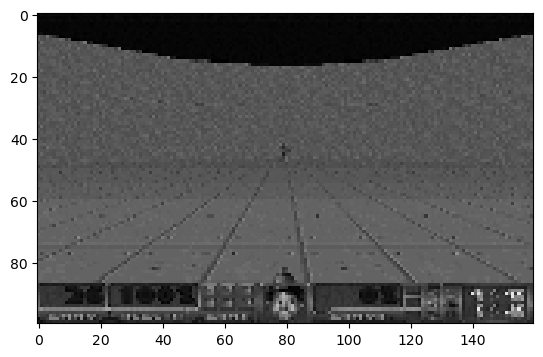

In [30]:
img, info = env.reset()

img.shape
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [31]:
env.close()

# Setup Callback

In [33]:
import os
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None: 
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path,
                'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

CHECKPOINT_DIR = './train/train_defcenter'
LOG_DIR = './logs/log_defcenter'

In [8]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Train Model 

In [9]:
from stable_baselines3 import PPO

env = VizDoomGym(render=False)
# n_step set relative to 300 eposides
model = PPO('CnnPolicy', env, device='cuda', tensorboard_log=LOG_DIR, 
    verbose=1, learning_rate=0.0001, n_steps=4096)
    #verbose=1, learning_rate=0.0001, n_steps=256) -- old config; perform really bad

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [12]:
# Do not start training from a previous (bad) model
model.learn(total_timesteps=100000, reset_num_timesteps=False, callback=callback)

Logging to ./logs/log_basic/PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.52     |
|    ep_rew_mean     | 72.2     |
| time/              |          |
|    fps             | 808      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 5.99       |
|    ep_rew_mean          | 79         |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.16515778 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.181     |
|    explained_variance   | 0.326      |
|    learni

# Test the Model

In [12]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

model = PPO.load(CHECKPOINT_DIR+'/best_model_100000')
env = VizDoomGym(render=True)
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

print(mean_reward)
env.close()

/home/stark/Tools/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


82.6


In [13]:
# Or we can write our own logic

env = VizDoomGym(render=True)
total_reward = 0

for episode in range(5):
    obs = env.reset()[0]
    done = False 
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        time.sleep(0.05)
        total_reward += reward
    print(total_reward)
    time.sleep(2)

env.close()

75.0
162.0
257.0
336.0
373.0
